# MOM01 KDS75 Ross Gyre Analysis

This notebook contains analysis of the 1/10th degree,
75-vertical level MOM5-SIS configuration run by Paul
Spence. Most plots are from the last year (or last
several years) of a 109-year spinup simulation forced
by CORE-NYF. 


In [12]:
# Load modules
%pylab inline

# Load modules
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large',
          'figure.facecolor':'white',
          'axes.facecolor':'white',
          'savefig.facecolor':'white',
          'contour.negative_linestyle':'solid'}
pylab.rcParams.update(params)

from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import xarray as xr

from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage

from joblib import Memory

memory = Memory(cachedir='/g/data1/v45/cosima-cookbook/', verbose=0)

Populating the interactive namespace from numpy and matplotlib


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'var', 'square', 'cm', 'sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Start a parallel cluster:
cc.start_cluster(diagnostics_port=8787)

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 8787:127.0.0.1:8787 vdi-n14.nci.org.au -l rmh561


<Client: scheduler='tcp://127.0.0.1:46526' processes=4 cores=8>

In [9]:
# Build index (only if new runs)
cc.build_index()

Files found but not yet indexed: 0
No new .nc files found.


True

In [3]:
# Explore the different runs:
configuration = 'mom01v5'
#expts = cc.get_experiments(configuration)
#display(expts)
# Long control run lengths:
# GFDL50 - 75 years
# KDS75 - 109 years
# kds75_cp - 130 years - initialized from KDS75 with different outputs.
# expt='KDS75'
expt='kds75_cp'

In [4]:
# Explore given files:
cc.get_ncfiles(expt)


['ocean.nc', 'ocean_grid.nc', 'ice_month.nc', 'ocean_month.nc']

In [11]:
cc.get_variables(expt,'ocean.nc')

['xt_ocean',
 'yt_ocean',
 'time',
 'nv',
 'xu_ocean',
 'yu_ocean',
 'st_ocean',
 'st_edges_ocean',
 'sw_ocean',
 'sw_edges_ocean',
 'grid_xt_ocean',
 'grid_yu_ocean',
 'potrho',
 'potrho_edges',
 'geolon_t',
 'geolat_t',
 'geolon_c',
 'geolat_c',
 'temp',
 'salt',
 'age_global',
 'u',
 'v',
 'sea_level',
 'sea_levelsq',
 'wt',
 'pot_rho_0',
 'mld',
 'pme_river',
 'net_sfc_heating',
 'tau_x',
 'tau_y',
 'tx_trans',
 'ty_trans',
 'ty_trans_rho',
 'diff_cbt_t',
 'average_T1',
 'average_T2',
 'average_DT',
 'time_bounds']

In [4]:
# Output location for plots:
OutDir = '/g/data/e14/rmh561/MOM01_RossGyre/'

In [9]:
# Get time info:
darray = cc.get_nc_variable(expt,'ocean.nc','time',n=4)
np.shape(darray)


HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=4), HTML(value='')))

(4,)

# Global Average Temperature Time Series:

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=379), HTML(value='')))

Text(0,0.5,'Global Average Temperature ($^\\circ$C)')

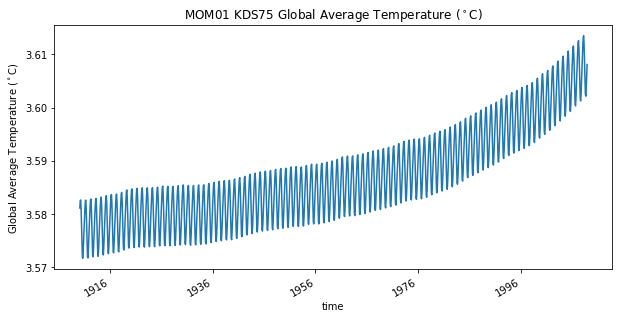

In [26]:
f = plt.figure(figsize=(10,5))
f.set_facecolor('white')
darray = cc.get_nc_variable('KDS75','ocean_scalar.nc','temp_global_ave')
darray.plot()
#darray[-12*4:].plot()
#darray = cc.get_nc_variable('kds75_cp','ocean_scalar.nc','temp_global_ave')
#darray.plot()
plt.title('MOM01 KDS75 Global Average Temperature ($^\circ$C)')
ax = plt.gca()
ax.set_ylabel('Global Average Temperature ($^\circ$C)')
#plt.savefig(OutDir + 'GlobalTempSpinup.png')


# Bathymetry:

In [24]:
# Load variable:
var= cc.get_nc_variable(expt,'ocean_grid.nc','ht',n=1,time_units='days since 1860-01-01',use_bag=True,)
ht = var.isel(time=0).sel(xt_ocean=slice(-220,-80)).sel(yt_ocean=slice(-80,-50))#resample(time='A').mean()
ht.load();

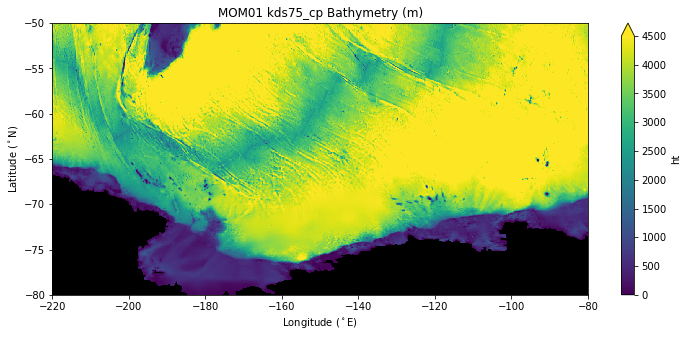

In [25]:
# Plot:
f = plt.figure(figsize=(12,5))
f.set_facecolor('white')
ht.plot.pcolormesh(vmin=0., vmax=4500.)
plt.title('MOM01 %s Bathymetry (m)' % expt)
ax = plt.gca();ax.set_facecolor('black')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'bathy.png')

# Barotropic Streamfunction:

In [21]:
# Load Psi:
var= cc.get_nc_variable(expt,'ocean.nc','tx_trans',n=4,time_units='days since 1860-01-01',use_bag=True,)
mask = var.sel(xu_ocean=slice(-220,-80)).sel(yt_ocean=slice(-90,-50)).isel(st_ocean=0).isel(time=0)
psi = var.sel(xu_ocean=slice(-220,-80)).sel(yt_ocean=slice(-90,-50)).sum('st_ocean').cumsum('yt_ocean')
psi.load();mask.load();

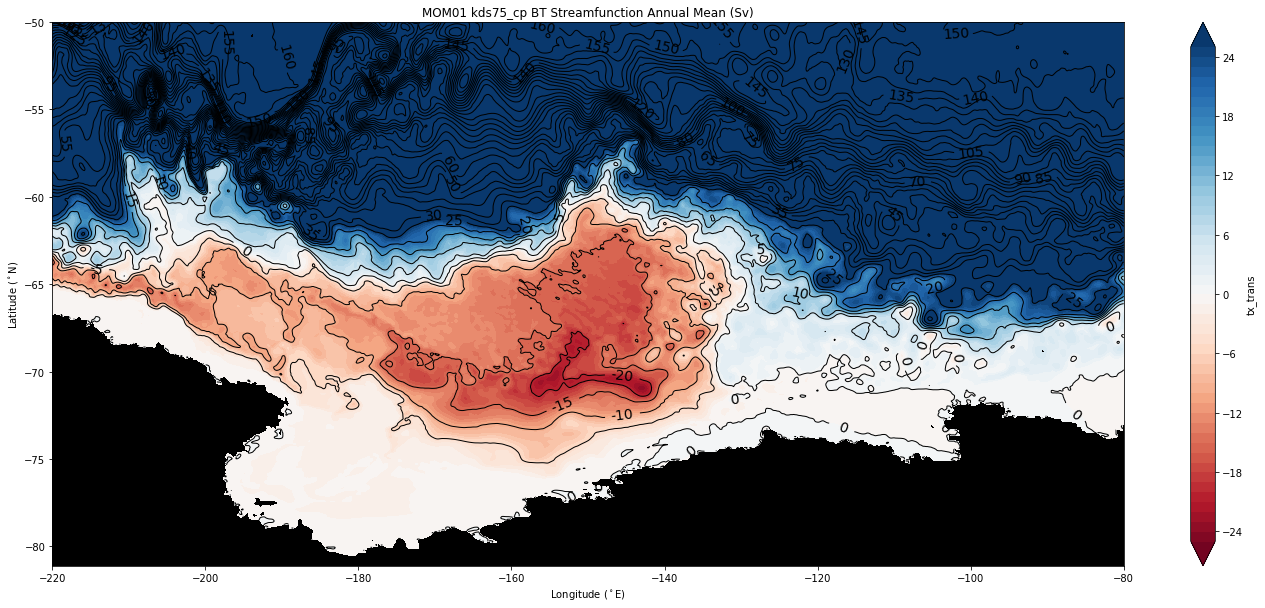

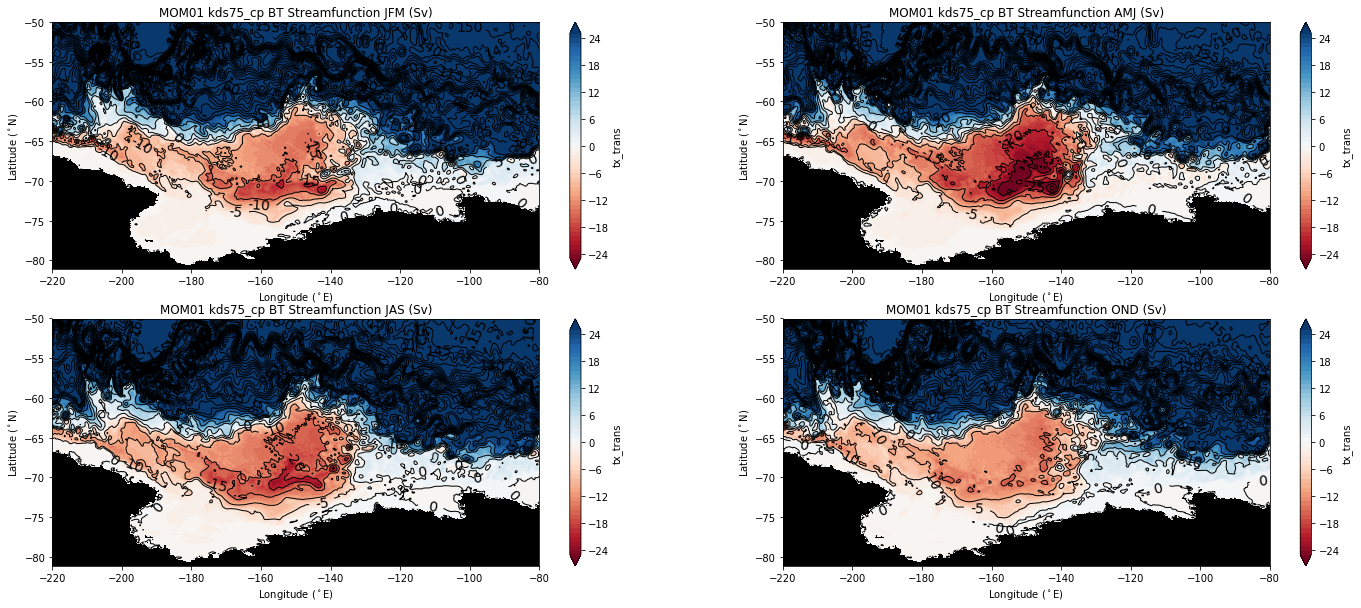

In [22]:
# Plot annual mean:
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
psi.mean('time').where(np.isnan(mask) == 0).plot.contourf(cmap='RdBu',levels=np.arange(-25.,26.,1.),extend='both')
CS = psi.mean('time').where(np.isnan(mask) == 0).plot.contour(levels=np.arange(-250.,255.,5.),colors='k',linewidths=1)
plt.clabel(CS, fmt='%2.0f', colors='k', fontsize=14)
plt.title('MOM01 %s BT Streamfunction Annual Mean (Sv)' % expt)
ax = plt.gca();ax.set_facecolor('black')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'BTStrm_AnnualMean.png')

# Plot seasons:
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
labs = ['JFM','AMJ','JAS','OND'];
for ii in range(4):
    plt.subplot(2,2,ii+1)
    psi.isel(time=ii).where(np.isnan(mask) == 0).plot.contourf(cmap='RdBu',levels=np.arange(-25.,26.,1.),extend='both')
    CS = psi.isel(time=ii).where(np.isnan(mask) == 0).plot.contour(levels=np.arange(-250.,255.,5.),colors='k',linewidths=1)
    plt.clabel(CS, fmt='%2.0f', colors='k', fontsize=14)
    plt.title(('MOM01 %s BT Streamfunction ' % expt) + labs[ii] + ' (Sv)')
    ax = plt.gca();ax.set_facecolor('black')
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'BTStrm.png')
    

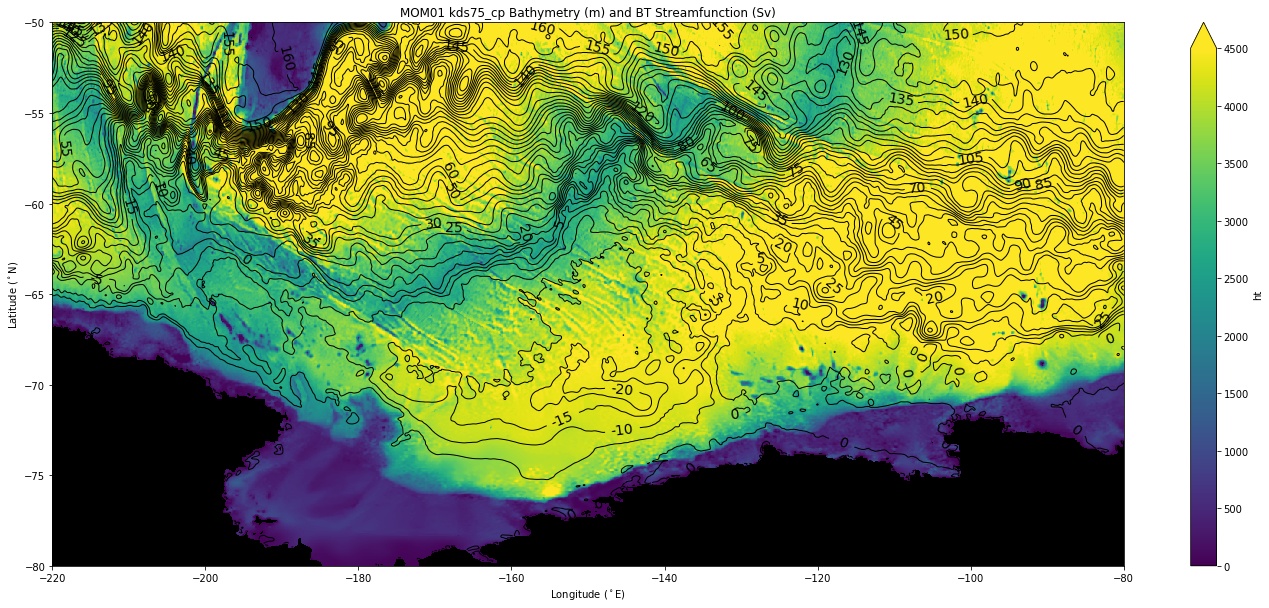

In [27]:
# Plot annual mean BT streamufunction with topography:
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
ht.plot.pcolormesh(vmin=0., vmax=4500.)
CS = psi.mean('time').where(np.isnan(mask) == 0).plot.contour(levels=np.arange(-250.,255.,5.),colors='k',linewidths=1)
plt.clabel(CS, fmt='%2.0f', colors='k', fontsize=14)
plt.title('MOM01 %s Bathymetry (m) and BT Streamfunction (Sv)' % expt)
ax = plt.gca();ax.set_facecolor('black')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'BTStrm_AnnualMean_Bathy.png')


## Sea Surface Height:

In [14]:
# Load MOM ssh:
var= cc.get_nc_variable(expt,'ocean.nc','sea_level',n=4,time_units='days since 1860-01-01',use_bag=True,)
ssh = var.sel(xt_ocean=slice(-220,-80)).sel(yt_ocean=slice(-80,-50))
ssh.load();

In [15]:
# Load Cryosat SSH for Comparison:
CryoSSH = xr.open_mfdataset('/g/data/e14/rmh561/MOM01_RossGyre/CS2_combined_Southern_Ocean_2011-2016.nc',engine='netcdf4',concat_dim='date',decode_times=False)
cryoLON = np.ndarray.flatten(CryoSSH.Longitude.values);cryoLAT = np.ndarray.flatten(CryoSSH.Latitude.values)
cryoLON[cryoLON>0.] = cryoLON[cryoLON>0.]-360.;glon, glat = np.meshgrid(ssh.xt_ocean.values,ssh.yt_ocean.values)
meanSSH = CryoSSH.DOT.mean('date')/100.
# Interpolate to MOM grid in region:
meanSSHint = scipy.interpolate.griddata((cryoLON,cryoLAT), np.ndarray.flatten(meanSSH.values), (glon,glat) , method='linear')

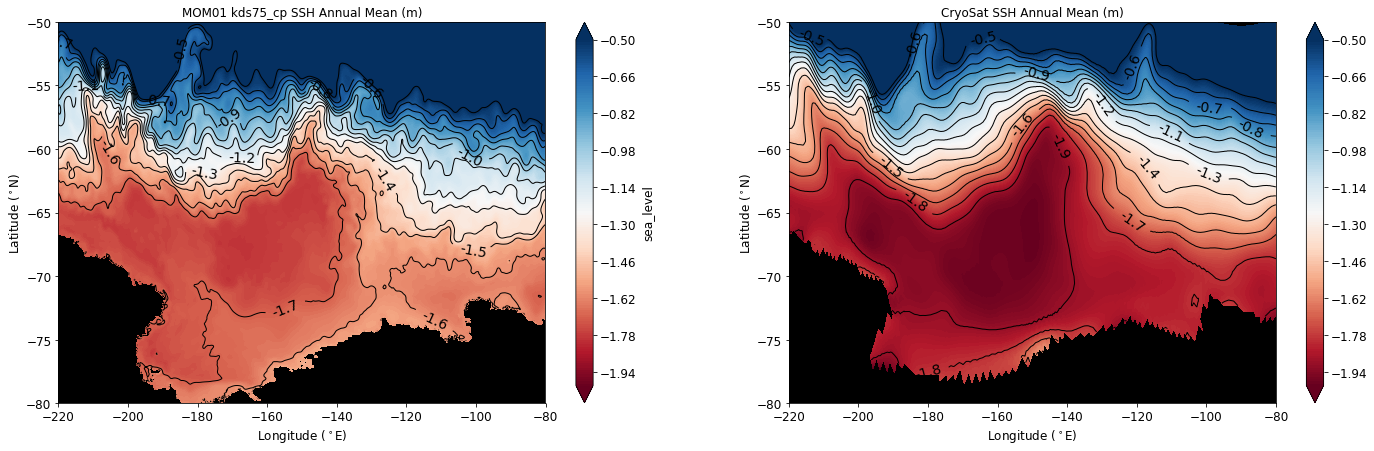

In [16]:
# Plot annual mean OBS vs. MOM:
f = plt.figure(figsize=(24,7))
f.set_facecolor('white')
plt.subplot(1,2,1)
ssh.mean('time').plot.contourf(cmap='RdBu',levels=np.arange(-2.0,-0.49,0.01),extend='both')
CS = ssh.mean('time').plot.contour(levels=np.arange(-2.1,-0.4,0.1),colors='k',linewidths=1)
plt.clabel(CS, fmt='%2.1f', colors='k', fontsize=14)
plt.title('MOM01 %s SSH Annual Mean (m)' % expt)
ax = plt.gca();ax.set_facecolor('black')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')

plt.subplot(1,2,2)
plt.contourf(ssh.xt_ocean,ssh.yt_ocean,meanSSHint,cmap='RdBu',levels=np.arange(-2.0,-0.49,0.01),extend='both')
plt.colorbar()
CS = plt.contour(ssh.xt_ocean,ssh.yt_ocean,meanSSHint,levels=np.arange(-2.1,-0.4,0.1),colors='k',linewidths=1)
plt.clabel(CS, fmt='%2.1f', colors='k', fontsize=14)
plt.title('CryoSat SSH Annual Mean (m)')
ax = plt.gca();ax.set_facecolor('black')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')

plt.savefig(OutDir + 'SSH_AnnualMean.png')


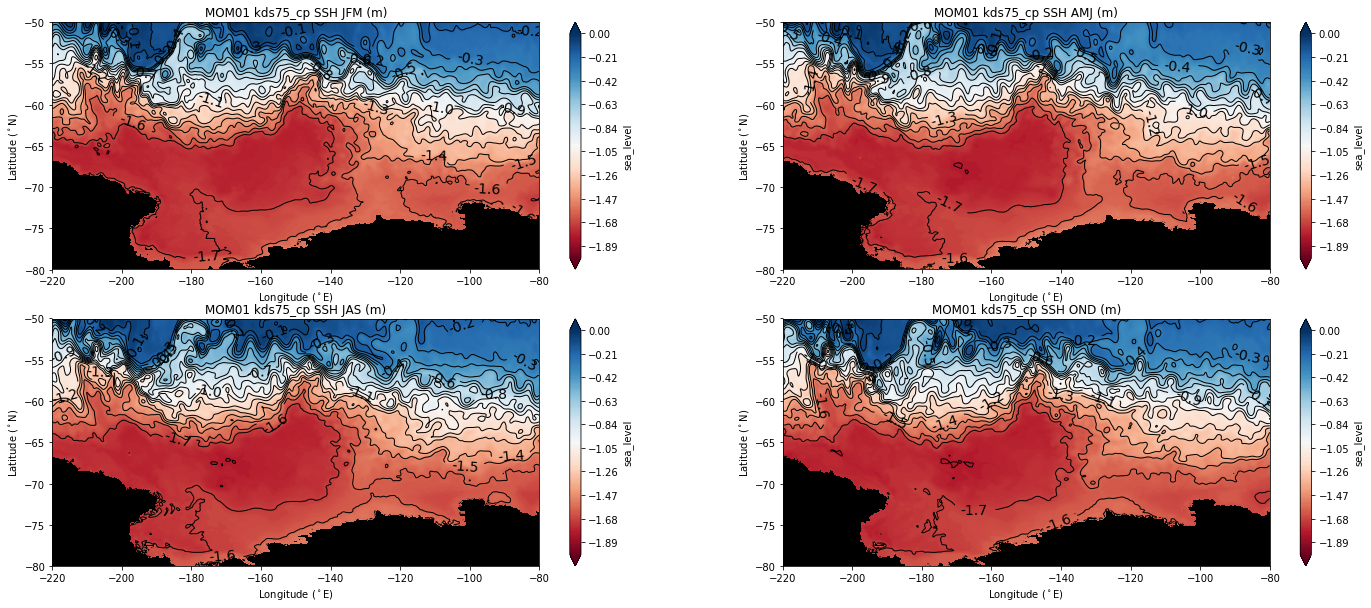

In [8]:
# Plot seasonal cycle from MOM:
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
labs = ['JFM','AMJ','JAS','OND'];
for ii in range(4):
    plt.subplot(2,2,ii+1)
    ssh.isel(time=ii).plot.contourf(cmap='RdBu',levels=np.arange(-2.0,0.01,0.01),extend='both')
    CS = ssh.isel(time=ii).plot.contour(levels=np.arange(-2.0,0.1,0.1),colors='k',linewidths=1)
    plt.clabel(CS, fmt='%2.1f', colors='k', fontsize=14)
    plt.title(('MOM01 %s SSH ' % expt) + labs[ii] + ' (m)')
    ax = plt.gca();ax.set_facecolor('black')
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'SSH.png')


# Mixed Layer Depth:

In [29]:
# Load mld:
var= cc.get_nc_variable(expt,'ocean_month.nc','mld',n=4,time_units='days since 1860-01-01',use_bag=True,)
mld = var.sel(xt_ocean=slice(-220,-80)).sel(yt_ocean=slice(-80,-50))
mld.load();

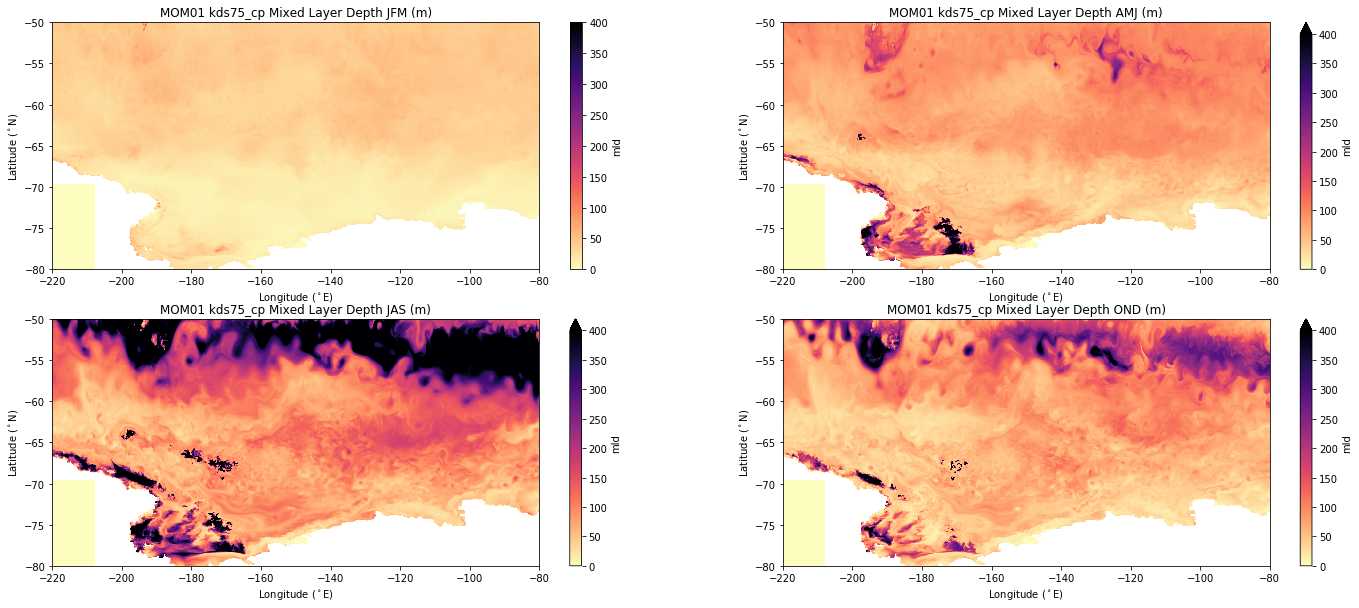

In [30]:
# Spatial plot of MLD:
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
labs = ['JFM','AMJ','JAS','OND'];
for ii in range(4):
    plt.subplot(2,2,ii+1)
    mld.isel(time=slice(ii*3,ii*3+3)).mean('time').plot.pcolormesh(cmap='magma_r',vmin=0, vmax=400)
    plt.title(('MOM01 %s Mixed Layer Depth ' % expt) + labs[ii] + ' (m)')
    ax = plt.gca();ax.set_facecolor('white')
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'MLD.png')

# Sea Surface Temperature

In [31]:
# Load variable:
var= cc.get_nc_variable(expt,'ocean.nc','temp',n=4,time_units='days since 1860-01-01',use_bag=True,)
sst = var.isel(st_ocean=0).sel(xt_ocean=slice(-220,-80)).sel(yt_ocean=slice(-80,-50))
sst.load();

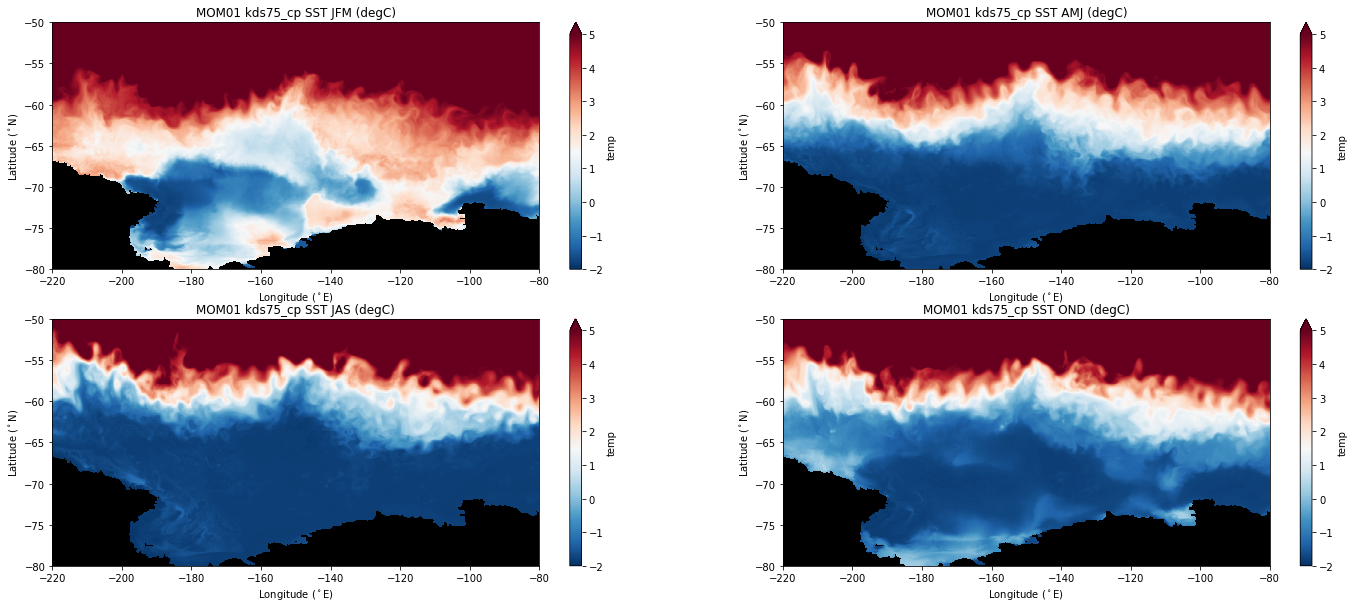

In [32]:
# Spatial plot of SST:
labs = ['JFM','AMJ','JAS','OND'];
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
for ii in range(4):
    plt.subplot(2,2,ii+1)
    sst.isel(time=ii).plot.pcolormesh(cmap='RdBu_r',vmin=-2., vmax=5.)
    plt.title(('MOM01 %s SST ' % expt) + labs[ii] + ' (degC)')
    ax = plt.gca();ax.set_facecolor('black')
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'SST.png')

# Sea Surface Salinity

In [33]:
# Load Variable:
var= cc.get_nc_variable(expt,'ocean.nc','salt',n=4,time_units='days since 1860-01-01',use_bag=True)
sss = var.isel(st_ocean=0).sel(xt_ocean=slice(-220,-80)).sel(yt_ocean=slice(-80,-50))#resample(time='A').mean()
sss.load();

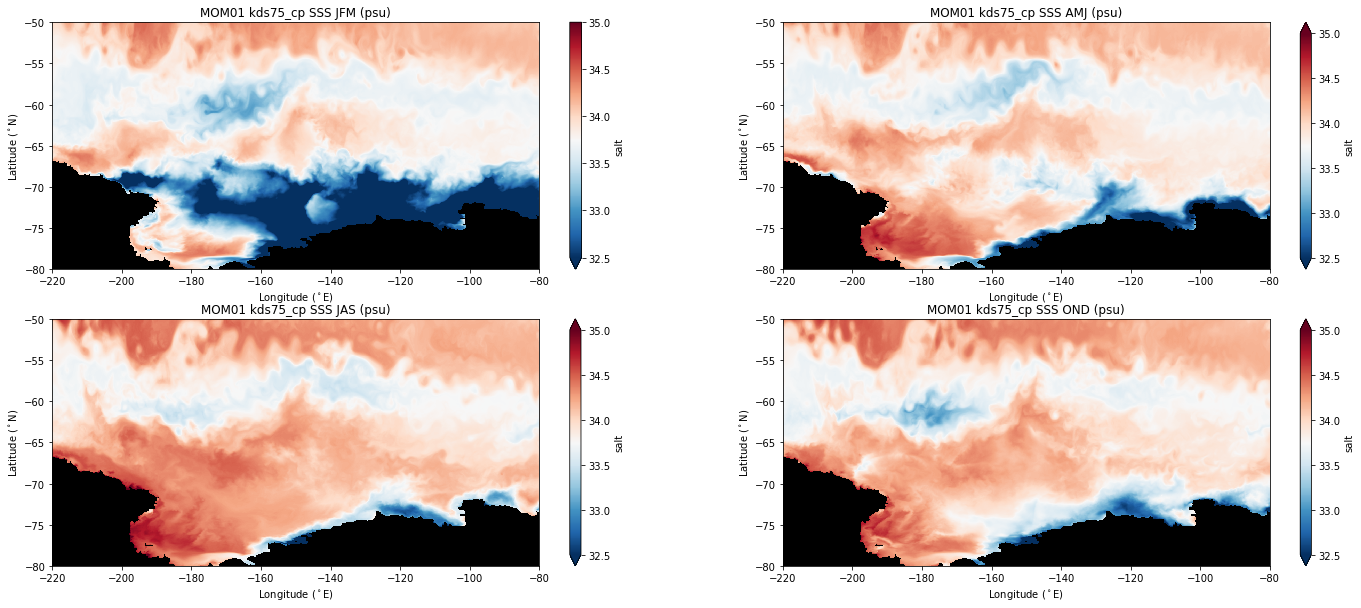

In [34]:
# Spatial plot of SSS:
labs = ['JFM','AMJ','JAS','OND'];
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
for ii in range(4):
    plt.subplot(2,2,ii+1)
    sss.isel(time=ii).plot.pcolormesh(cmap='RdBu_r',vmin=32.5, vmax=35.)
    plt.title(('MOM01 %s SSS ' % expt) + labs[ii] + ' (psu)')
    ax = plt.gca();ax.set_facecolor('black')
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'SSS.png')

# Sea Surface Density

In [35]:
# Load variable:
var= cc.get_nc_variable(expt,'ocean.nc','pot_rho_0',n=4,time_units='days since 1860-01-01',use_bag=True,)
rho = var.isel(st_ocean=0).sel(xt_ocean=slice(-220,-80)).sel(yt_ocean=slice(-80,-50))
rho.load();

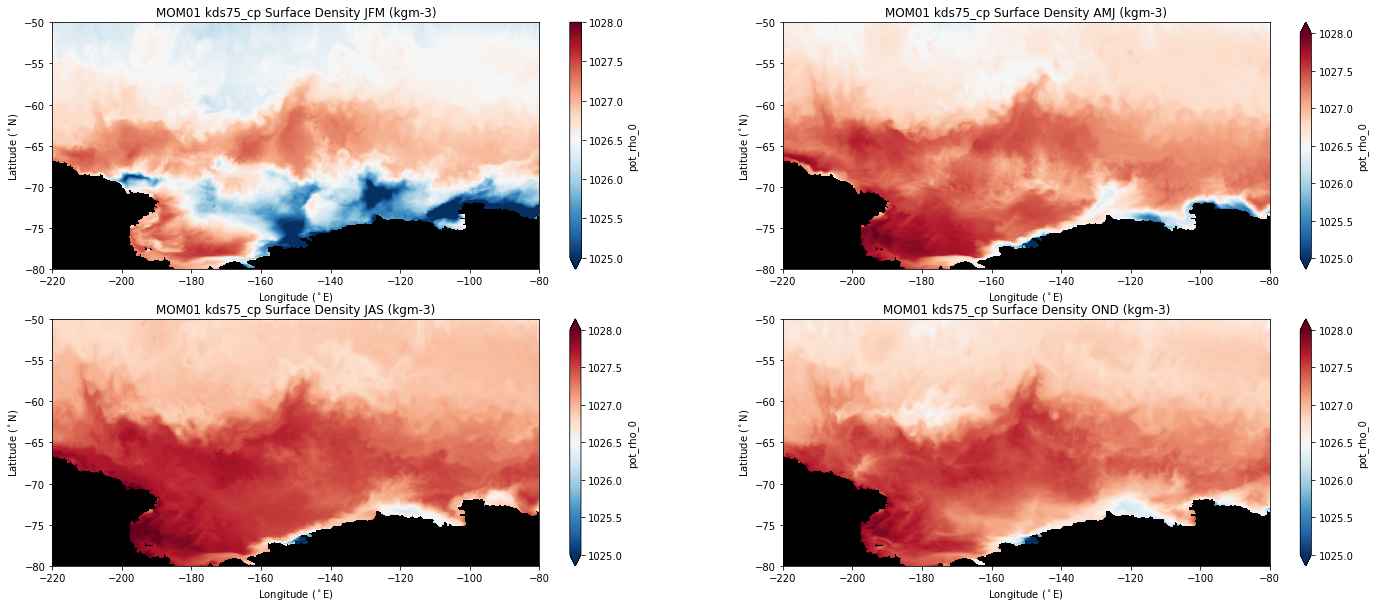

In [36]:
# Spatial plot of surface rho:
labs = ['JFM','AMJ','JAS','OND'];
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
for ii in range(4):
    plt.subplot(2,2,ii+1)
    rho.isel(time=ii).plot.pcolormesh(cmap='RdBu_r',vmin=1025., vmax=1028.)
    plt.title(('MOM01 %s Surface Density ' % expt) + labs[ii] + ' (kgm-3)')
    ax = plt.gca();ax.set_facecolor('black')
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'srho.png')

# Ice Concentration

In [37]:
# Load ice:
var= cc.get_nc_variable(expt,'ice_month.nc','CN',n=4,time_units='days since 1860-01-01',use_bag=True,)
ice = var.sel(xt=slice(-220,-80)).sel(yt=slice(-80,-50)).sum('ct')
ice.load();


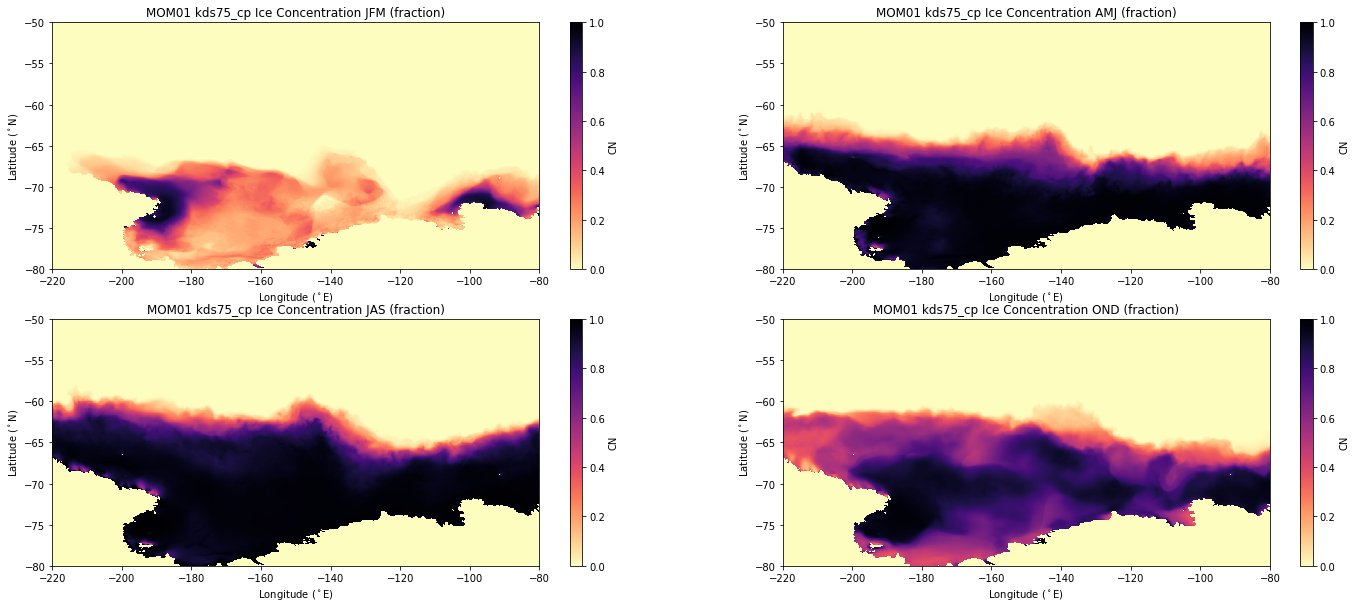

In [38]:
# Spatial plot of ice:
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
labs = ['JFM','AMJ','JAS','OND'];
for ii in range(4):
    plt.subplot(2,2,ii+1)
    ice.isel(time=slice(ii*3,ii*3+3)).mean('time').plot.pcolormesh(cmap='magma_r',vmin=0., vmax=1.)
    plt.title(('MOM01 %s Ice Concentration ' %expt) + labs[ii] + ' (fraction)')
    ax = plt.gca();ax.set_facecolor('black')
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'ice.png')


# Eddy Kinetic Energy

In [39]:
# Load velocities from 10-years of data and calculate EKE (takes a while...):
u= cc.get_nc_variable(expt,'ocean.nc','u',n=4*10,time_units='days since 1860-01-01',use_bag=True).isel(st_ocean=0).sel(xu_ocean=slice(-220,-80)).sel(yu_ocean=slice(-80,-50))
v= cc.get_nc_variable(expt,'ocean.nc','u',n=4*10,time_units='days since 1860-01-01',use_bag=True).isel(st_ocean=0).sel(xu_ocean=slice(-220,-80)).sel(yu_ocean=slice(-80,-50))
EKE = 0.5 * ((u - u.mean('time'))**2 + (v - v.mean('time'))**2)
EKE = cc.compute_by_block(EKE)

HBox(children=(IntProgress(value=0, max=480), HTML(value='')))

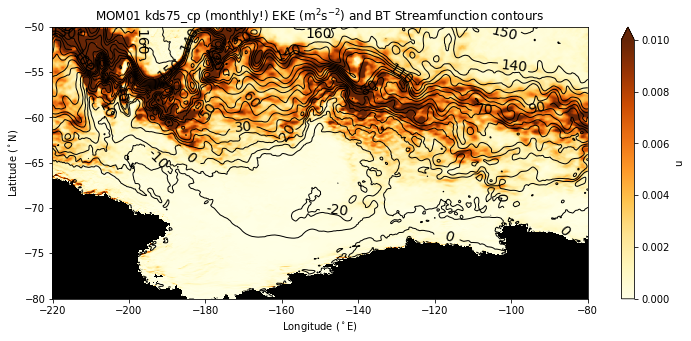

In [41]:
# Spatial plot of EKE:
labs = ['JFM','AMJ','JAS','OND'];
f = plt.figure(figsize=(12,5))
f.set_facecolor('white')
EKE.mean('time').plot.pcolormesh(cmap='YlOrBr',vmin=0., vmax=0.01)
# Add BT Streamfunction contours:
CS = psi.mean('time').where(np.isnan(mask) == 0).plot.contour(levels=np.arange(-250.,260.,10.),colors='k',linewidths=1)
plt.clabel(CS, fmt='%2.0f', colors='k', fontsize=14)
plt.title('MOM01 %s (monthly!) EKE (m$^2$s$^{-2}$) and BT Streamfunction contours' % expt)
ax = plt.gca();ax.set_facecolor('black')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'EKE.png')

## Sea Surface Height Variability

In [17]:
# Load monthly SSH data:
var= cc.get_nc_variable(expt,'ice_month.nc','SSH',n=40,time_units='days since 1860-01-01',use_bag=True,)
ssh = var.sel(xt=slice(-220,-80)).sel(yt=slice(-80,-50))
ssh.load();
sshvar = np.std(ssh - ssh.mean('time'),axis=0)

In [18]:
# Load Cryosat SSH for Comparison:
CryoSSH = xr.open_mfdataset('/g/data/e14/rmh561/MOM01_RossGyre/CS2_combined_Southern_Ocean_2011-2016.nc',engine='netcdf4',concat_dim='date',decode_times=False)
cryoLON = np.ndarray.flatten(CryoSSH.Longitude.values);cryoLAT = np.ndarray.flatten(CryoSSH.Latitude.values)
cryoLON[cryoLON>0.] = cryoLON[cryoLON>0.]-360.;glon, glat = np.meshgrid(ssh.xt.values,ssh.yt.values)
meanSSH = CryoSSH.DOT.mean('date')/100.
# Interpolate to MOM grid in region:
cryoSSHint = np.zeros([len(glon[:,0]),len(glon[0,:]),len(CryoSSH.date.values)])
for ii in range(len(CryoSSH.date.values)):
    if ii % 5 == 0:
        print('Doing Month %d of %d' %(ii,len(CryoSSH.date.values)))
    cryoSSHint[:,:,ii] = scipy.interpolate.griddata((cryoLON,cryoLAT), np.ndarray.flatten(CryoSSH.isel(date=ii).DOT.values/100.), (glon,glat) , method='linear')
meanSSHint = scipy.interpolate.griddata((cryoLON,cryoLAT), np.ndarray.flatten(meanSSH.values), (glon,glat) , method='linear')
Cryosshvar = np.nanstd(cryoSSHint,axis=2)


Doing Month 0 of 72


Doing Month 5 of 72


Doing Month 10 of 72


Doing Month 15 of 72


Doing Month 20 of 72


Doing Month 25 of 72


Doing Month 30 of 72


Doing Month 35 of 72


Doing Month 40 of 72


Doing Month 45 of 72


Doing Month 50 of 72


Doing Month 55 of 72


Doing Month 60 of 72


Doing Month 65 of 72


Doing Month 70 of 72


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


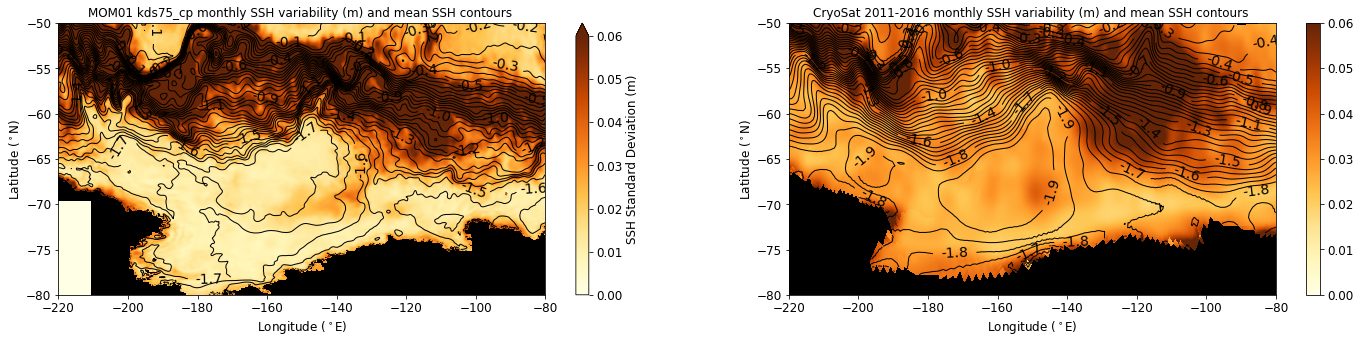

In [22]:
# Spatial plot of SSH variability from both OBS and Model:
f = plt.figure(figsize=(24,5))
f.set_facecolor('white')
plt.subplot(1,2,1)
cm = sshvar.plot.pcolormesh(cmap='YlOrBr',vmin=0., vmax=0.06)
# Add mean SSH contours:
CS = ssh.mean('time').plot.contour(levels=np.arange(-2.,0.05,0.05),colors='k',linewidths=1)
plt.clabel(CS, fmt='%2.1f', colors='k', fontsize=14)
plt.title('MOM01 %s monthly SSH variability (m) and mean SSH contours ' % expt)
cm.colorbar.set_label('SSH Standard Deviation (m)')
ax = plt.gca();ax.set_facecolor('black')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')

plt.subplot(1,2,2)
plt.pcolormesh(ssh.xt,ssh.yt,Cryosshvar,cmap='YlOrBr',vmin=0., vmax=0.06)
plt.colorbar()
# Add SH
CS = plt.contour(ssh.xt,ssh.yt,meanSSHint,levels=np.arange(-2.,0.05,0.05),colors='k',linewidths=1)
plt.clabel(CS, fmt='%2.1f', colors='k', fontsize=14)
plt.title('CryoSat 2011-2016 monthly SSH variability (m) and mean SSH contours ')
cm.colorbar.set_label('SSH Standard Deviation (m)')
ax = plt.gca();ax.set_facecolor('black')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.set_ylabel('Latitude ($^\circ$N)')

plt.savefig(OutDir + 'SSHvar.png')

# Surface Velocity

In [42]:
# Load Variable:
u= cc.get_nc_variable(expt,'ocean.nc','u',n=4,time_units='days since 1860-01-01',use_bag=True)
v= cc.get_nc_variable(expt,'ocean.nc','u',n=4,time_units='days since 1860-01-01',use_bag=True)
svel = np.sqrt((u.isel(st_ocean=0).sel(xu_ocean=slice(-220,-80)).sel(yu_ocean=slice(-80,-50)))**2+(v.isel(st_ocean=0).sel(xu_ocean=slice(-220,-80)).sel(yu_ocean=slice(-80,-50)))**2)
svel.load();

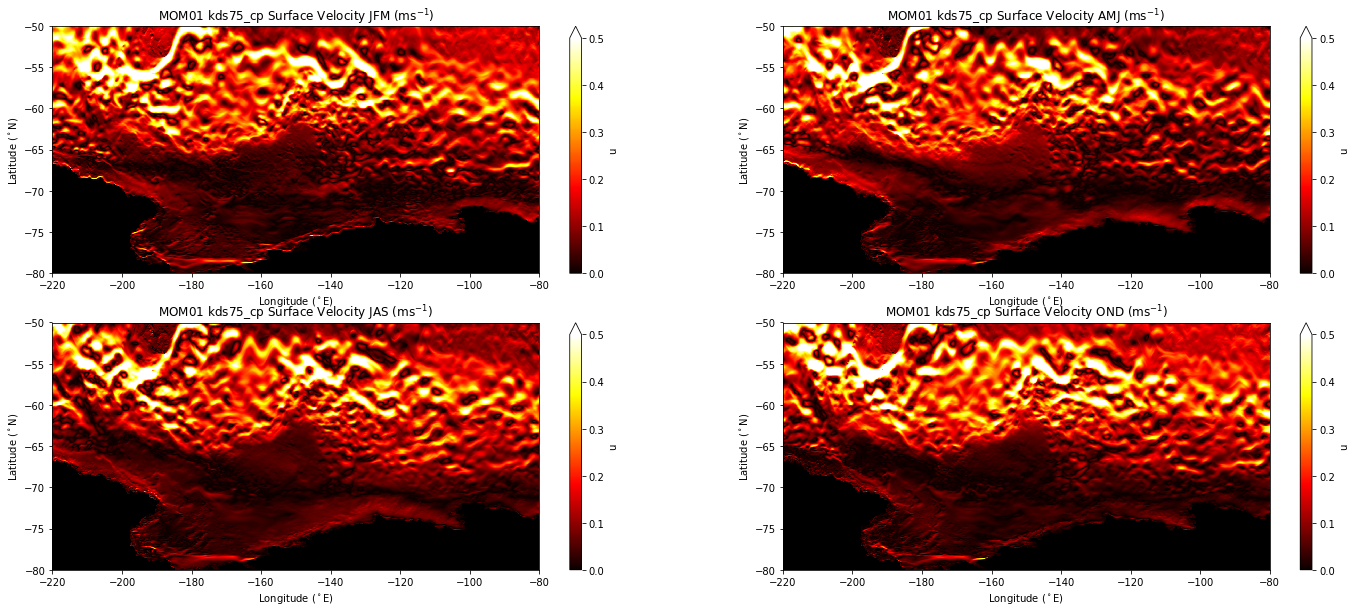

In [43]:
# Spatial plot of surface velocity:
labs = ['JFM','AMJ','JAS','OND'];
f = plt.figure(figsize=(24,10))
f.set_facecolor('white')
for ii in range(4):
    plt.subplot(2,2,ii+1)
    svel.isel(time=ii).plot.pcolormesh(cmap='hot',vmin=0., vmax=0.5)
    plt.title(('MOM01 %s Surface Velocity ' % expt) + labs[ii] + ' (ms$^{-1}$)')
    ax = plt.gca();ax.set_facecolor('black')
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
plt.savefig(OutDir + 'SVel.png')

# Overturning circulation

HBox(children=(IntProgress(value=0, description='get_nc_variable:', max=4), HTML(value='')))

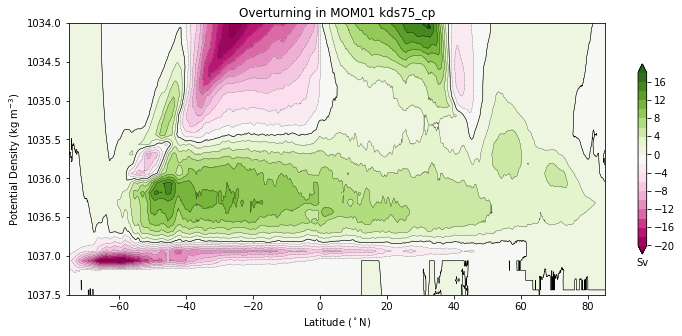

In [44]:
psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=4,
                          time_units = 'days since 1700-01-01')
psi = psi.sum('grid_xt_ocean')
psi_avg = psi.cumsum('potrho').mean('time') -  psi.sum('potrho').mean('time')
psi_avg.load()

f = plt.figure(figsize=(12, 5))
f.set_facecolor('white')
clev=np.arange(-20,20,2)
plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, psi_avg, 
                 cmap=plt.cm.PiYG,levels=clev,extend='both')
cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    
cb.ax.set_xlabel('Sv')
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=clev, colors='k', linewidths=0.25)
plt.contour(psi_avg.grid_yu_ocean, psi_avg.potrho, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
plt.gca().invert_yaxis()
    
plt.ylim((1037.5,1034))
plt.ylabel('Potential Density (kg m$^{-3}$)')
plt.xlabel('Latitude ($^\circ$N)')
plt.xlim([-75,85])
plt.title('Overturning in MOM01 %s' % expt)
plt.savefig(OutDir + 'Overturning.png')

In [ ]:
# Still to plot:
# Subsurface temperature/salinity/density